<div class=row>
    <div class=column>
        <img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=150 alt="Project Pythia Logo"></img>
    </div>
    <div class=column>
        <img src="images/logos/numpy_logo.svg" width=250 alt="NumPy Logo"></img>
    </div>
    <div class=column>
        <img src="images/logos/xarray_logo.png" width=250 alt="Xarray Logo"></img>
    </div>
</div>
<div class=row>
    <div class=column>
        <img src="images/logos/cartopy_logo.png" width=250 alt="Cartopy Logo"></img>
    </div>
    <div class=column>
        <img src="images/logos/geocat_logo.svg" width=300 alt="GeoCAT Logo"></img>
    </div>
    <div class=column>
        <img src="images/logos/matplotlib_logo.svg" width=300 alt="Matplotlib Logo"></img>
    </div>

# Matplotlib: Consistant Colorbars for Comparisons

---

## Overview
Analyzing data almost always requires comparing datasets, and when done visually, this is a powerful way to communicate changes. However, to do this acurately in color, the colormap used by the datasets must be the same. The colors on each plot must have the same meanings and values assigned to them. This cookbook shows how to:

1. create multiple plots but display only one colorbar
1. use the same colormap for multiple plots
1. choose accessible colormaps and explains best practices when using color
1. make custom colormaps (maybe)
1. adjust the sizing, shape, etc of colorbars (maybe)

## Prerequisites
TODO: time to learn, sys requirements
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html#overview) | Necessary | [Contour/Filled Contour Plots](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html#contour-and-filled-contour-plots) |
| [Basic Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) | Necessary | [Opening netCDF data](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) |
| GeoCAT-viz | Necessary | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports

In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmaps

import geocat.datafiles as gdf
import geocat.viz as gv

%matplotlib inline

/Users/hcraker/miniconda3/envs/colorbar-cookbook/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


## Loading in and preprocessing data

The data we are using for this example is from the [GeoCAT-datafiles](https://github.com/NCAR/geocat-datafiles) repository on GitHub. The specific file is `TS.cam3.toga_ENS.1950-2000.nc`, and it contains surafce temeprature data from the first run of the CAM3 T85 TOGA model run. We load the data file in using the xarray default engine.

In [2]:
ds = xr.open_dataset(gdf.get("netcdf_files/TS.cam3.toga_ENS.1950-2000.nc"),)
ds

/Users/hcraker/miniconda3/envs/colorbar-cookbook/lib/python3.10/site-packages/xarray/backends/plugins.py:98: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


<xarray.Dataset>
Dimensions:  (time: 612, lat: 128, lon: 256)
Coordinates:
  * time     (time) object 1950-02-01 00:00:00 ... 2001-01-01 00:00:00
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    TS       (time, lat, lon) float32 ...
Attributes:
    title:          CAM3 T85 TOGA Run #1 (eul128x256_d63vamip_trpsst_01), run...
    source_mss:     /BRUCEB/csm/eul128x256_d63vamip_trpsst_01/atm/hist/
    source:         /home/asphilli/DSets/t85toga.vartscreate.ncl
    creation_date:  Mon Jan 31 14:34:17 MST 2005
    history:        Fri Aug  5 13:31:09 2005: ncea CAM3TOGA01/TS.cam3.toga_01...

The file has data from different timesteps of the model. Say we want to plot temperature data from two different timesteps and compare them visually. To see the biggest change, let's choose a timestep from February and one from August in the same year. We also need to select the variable of interest which is `TS` for surface temperature.

To create the colorbar, we'll need to know what the minimum and maximum temperatures are. We find those here as well.

In [3]:
first_step = ds.isel(time=0).TS
last_step = ds.isel(time=6).TS
min_val = np.floor(min([first_step.min(), last_step.min()]).values)
max_val = np.ceil(max([first_step.max(), last_step.max()]).values)

## Making the Plot
Due to Jupyter Notebook limitations, the entire plot must be made in the same block. These are the general steps:

### Create the figure

We are using `matplotlib` and `cartopy` to make two plots on the same figure. We need to create the figure and specify our map projection before we can create the two subplots.

### Format and populate subplots

Once that's done, we need to format and populate the subplots. The for loop below ensures that both sets of axes are created with the same specifications. Most importantly, it makes sure that both plots are drawn with the same `levels` keyword for `contourf`. This keyword is what specifies how the colors are assigned to values. As long as `levels` is the same between contour plots, the images will be useful for making accurate comparisions.

### Making the colorbar

`contourf` returns a `QuadContourSet` object. This holds the information about how colors are assigned to values and where the contours are drawn. Since both plots were made with the same parameters, the returned objects are identical. Either can be passed into `plt.colorbar`.

To make the colorbar appear below both plots, the `ax` parameter must be set to the lower axes `ax2`. Then `orientation` is set to `'horizontal'`. Additional [keyword arguments](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar) can be passed in to `plt.colorbar` to further customize its appearance.

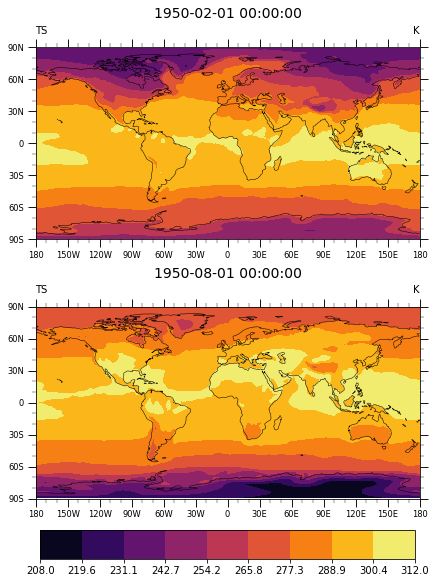

In [4]:
fig = plt.figure(figsize=(24, 8), constrained_layout=True)
proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(2,1,1, projection=proj)
ax2 = fig.add_subplot(2,1,2, projection=proj)

for ax, data in [[ax1, first_step], [ax2, last_step]]:
    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax=ax,
                                 xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major ticks
    gv.add_major_minor_ticks(ax)

    # Draw coastlines
    ax.coastlines(linewidth=0.5)

    # Use geocat.viz.util convenience function to set titles
    gv.set_titles_and_labels(ax,
                             maintitle=data.time.values,
                             lefttitle='TS',
                             righttitle='K',
                             maintitlefontsize=12,
                             lefttitlefontsize=10,
                             righttitlefontsize=10)
    mappable = ax.contourf(data['lon'], data['lat'], data.data, cmap='inferno', levels=np.linspace(min_val, max_val, 10))
    
cbar = fig.colorbar(mappable, ax=ax2, orientation='horizontal', aspect=13)

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!


Visualization & Analysis Systems Technologies. (2020). Geoscience Community Analysis Toolkit: GeoCAT-datafiles [Software]. Boulder, CO: UCAR/NCAR - Computational and Informational System Lab. [doi:10.5281/zenodo.6684782](doi:10.5281/zenodo.6684782).